<a href="https://colab.research.google.com/github/ferrazzijk/ALS-User-Product-Recommendation-System/blob/main/Instacart_Recs_Qty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instacart Recommendation System**

The task at hand for this project was to build a model that adds value by solving a problem. 

In my case, I set out to work on something I hadn’t done before, as a way to work outside my comfort or knowledge zone. When the description of the final capstone mentioned some popular platforms recommendation systems, I thought that would be the perfect opportunity to flex my everything is figureoutable muscle. I found data Instacart released for orders from 2017 and knew this was the perfect opportunity to add value during a time when more people are turning to online grocery shopping and delivery.  

Instacart, if you’re unfamiliar, is a platform, available through an app or website, that allows customers to order groceries, for pick up or delivery, from participating retailers with the shopping being done by a personal shopper. 

Analyzed data included Data for
*   62,000 Orders
*   41,000 Customers
*   134 Aisles
*   31,728 Products

The data comes from Kaggle and can be found [here](https://www.kaggle.com/c/instacart-market-basket-analysis/data). 


In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8MB 4.9MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670915 sha256=59aeb3f52c2ed6217e7fb3f4fa909e17afbb9c9831a4441422d69ab0910d609d
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 47kB/s 
     |████████████████████████████████| 204kB 45.3MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=83c3e48eb4fd4621a8bfb1500e6aaa0be3f807f60e20e3d881aa47b6b7a83c29
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [ ]:
#imports
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import  CrossValidator, ParamGridBuilder
from pyspark import SparkContext
from pyspark.sql import SQLContext

from scipy import sparse

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from statsmodels.tools.eval_measures import rmse

from surprise import Reader, Dataset
from surprise.model_selection import GridSearchCV

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#load data

aisles_url ='https://www.dropbox.com/s/rtbqufy50bgypi9/aisles.csv?dl=1'
aisles_df = pd.read_csv(aisles_url)

departments_url = 'https://www.dropbox.com/s/hpv6yn04rsthyrv/departments.csv?dl=1'
dept_df = pd.read_csv(departments_url)

products_url = 'https://www.dropbox.com/s/6dwc75clzye3d8z/products.csv?dl=1'
products_df = pd.read_csv(products_url)

orders_url = 'https://www.dropbox.com/s/wiqx62x4w0ekuny/orders.csv?dl=1'
orders_df = pd.read_csv(orders_url)

prior_orders_url ='https://www.dropbox.com/s/6q3wxgxg3zr42rn/prior%20orders.csv?dl=1'
prior_orders_df = pd.read_csv(prior_orders_url)

train_orders_url ='https://www.dropbox.com/s/emlm2b5tqdv7jxo/training%20orders.csv?dl=1'
train_orders_df = pd.read_csv(train_orders_url)

# **Dataframe Explanations**



*   **Aisles:** Contains different aisles
*   **Departments:** Contains different departments
*   **Products:** Descriptions of the Prodcuts
*   **Orders:** Tells which Orders are in the Training, Test, & Prior Sets
*   **Prior Orders:** Prior Orders of Users
*   **Test Orders:** Orders in Test Set
*   **Train Orders:** Orders in Training Set





# **Exploratory Data Analysis & Cleaning**

In [ ]:
#view aisles_df head & shape for initial inspection

print('Aisles Dataframe has {} rows and {} columns.'.format(aisles_df.shape[0], aisles_df.shape[1]))
aisles_df.head()

Aisles Dataframe has 134 rows and 2 columns.


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [ ]:
#view dept_df head & shape for initial inspection

print('Departments Dataframe has {} rows and {} columns.'.format(dept_df.shape[0], dept_df.shape[1]))
dept_df.head()

Departments Dataframe has 21 rows and 2 columns.


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [ ]:
#view products_df head & shape for initial inspection

print('Products Dataframe has {} rows and {} columns.'.format(products_df.shape[0], products_df.shape[1]))
products_df.head()

Products Dataframe has 49688 rows and 4 columns.


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
#view orders_df head & shape for initial inspection

print('Orders Dataframe has {} rows and {} columns.'.format(orders_df.shape[0], orders_df.shape[1]))
orders_df.head()

Orders Dataframe has 1048575 rows and 7 columns.


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
#view prior_orders_df head & shape for initial inspection

print('Prior Orders Dataframe has {} rows and {} columns.'.format(prior_orders_df.shape[0], prior_orders_df.shape[1]))
prior_orders_df.head()

Prior Orders Dataframe has 1048575 rows and 4 columns.


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [ ]:
#view train_orders_df head & shape for initial inspection

print('Training Orders Dataframe has {} rows and {} columns.'.format(train_orders_df.shape[0], train_orders_df.shape[1]))
train_orders_df.head()

Training Orders Dataframe has 1048575 rows and 4 columns.


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


**Merging Data**

It will be helpful to combine prior & training orders with aisles, departments, and products to further investiage data. 

In [ ]:
#concatenate prior & training dfs
order_details = pd.concat([prior_orders_df, train_orders_df], axis=0)

#merge in 'product_id', 'aisle_id', & 'department_id' from products_df
order_details = order_details.merge(products_df[['product_id', 'aisle_id', 'department_id']],
                how='inner', on='product_id')

#merge in aisles
order_details = order_details.merge(aisles_df, on = 'aisle_id')

#merge in departments
order_details = order_details.merge(dept_df, on='department_id')

#merge in orders
order_details = order_details.merge(orders_df[['order_id', 'user_id']], on='order_id')

#merge in products
order_details = order_details.merge(products_df[['product_id', 'product_name']], on= 'product_id')

#view 
order_details

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,aisle,department,user_id,product_name
0,120,33120,13,0,86,16,eggs,dairy eggs,23750,Organic Egg Whites
1,327,33120,5,1,86,16,eggs,dairy eggs,58707,Organic Egg Whites
2,623,33120,1,1,86,16,eggs,dairy eggs,37804,Organic Egg Whites
3,726,33120,3,1,86,16,eggs,dairy eggs,57362,Organic Egg Whites
4,1097,33120,14,1,86,16,eggs,dairy eggs,30502,Organic Egg Whites
...,...,...,...,...,...,...,...,...,...,...
638587,31925,24968,2,1,134,5,specialty wines champagnes,alcohol,47329,Sonoma Brut Sparkling Wine
638588,34570,49562,1,1,134,5,specialty wines champagnes,alcohol,37901,Blanc De Noirs Sparkling Wine
638589,2036125,22396,1,1,6,2,other,other,46854,Digital Pregnancy Test
638590,1611547,34152,2,0,6,2,other,other,9234,Water Based Personal Lubricant


In [ ]:
#rename add_to_cart_order 
order_details.rename(columns={'add_to_cart_order':'qty_purchased'}, inplace=True)

#reorder columns & ignore reordered
order_details = order_details[['user_id','order_id','product_id', 'product_name',
'qty_purchased', 'aisle_id', 'aisle', 'department_id', 'department']]

#view
order_details

,user_id,order_id,product_id,product_name,qty_purchased,aisle_id,aisle,department_id,department
0,23750,120,33120,Organic Egg Whites,13,86,eggs,16,dairy eggs
1,58707,327,33120,Organic Egg Whites,5,86,eggs,16,dairy eggs
2,37804,623,33120,Organic Egg Whites,1,86,eggs,16,dairy eggs
3,57362,726,33120,Organic Egg Whites,3,86,eggs,16,dairy eggs
4,30502,1097,33120,Organic Egg Whites,14,86,eggs,16,dairy eggs
...,...,...,...,...,...,...,...,...,...
638587,47329,31925,24968,Sonoma Brut Sparkling Wine,2,134,specialty wines champagnes,5,alcohol
638588,37901,34570,49562,Blanc De Noirs Sparkling Wine,1,134,specialty wines champagnes,5,alcohol
638589,46854,2036125,22396,Digital Pregnancy Test,1,6,other,2,other
638590,9234,1611547,34152,Water Based Personal Lubricant,2,6,other,2,other


In [ ]:
#View data types
order_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638592 entries, 0 to 638591
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        638592 non-null  int64 
 1   order_id       638592 non-null  int64 
 2   product_id     638592 non-null  int64 
 3   product_name   638592 non-null  object
 4   qty_purchased  638592 non-null  int64 
 5   aisle_id       638592 non-null  int64 
 6   aisle          638592 non-null  object
 7   department_id  638592 non-null  int64 
 8   department     638592 non-null  object
dtypes: int64(6), object(3)
memory usage: 48.7+ MB


**Missing Data**

I don't anticipate missing data due to source of data, but it doesn't hurt to check. 

In [ ]:
#missing data check
total_missing = order_details.isnull().sum().sort_values(ascending=False)
percent_missing = (order_details.isnull().sum()/order_details.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
department,0,0.0
department_id,0,0.0
aisle,0,0.0
aisle_id,0,0.0
qty_purchased,0,0.0
product_name,0,0.0
product_id,0,0.0
order_id,0,0.0
user_id,0,0.0


## **Creating New Dataframes that will be used later on.**

**User Product History**

Used in Personalized Recommender System

In [ ]:
#create a df of user product history
user_product_hist = order_details[['product_id','product_name', 'user_id','qty_purchased']].groupby(['product_id','product_name','user_id']).sum().reset_index()
user_product_hist = pd.DataFrame(data=user_product_hist)

In [ ]:
user_product_hist

,product_id,product_name,user_id,qty_purchased
0,1,Chocolate Sandwich Cookies,751,4
1,1,Chocolate Sandwich Cookies,1540,7
2,1,Chocolate Sandwich Cookies,2221,5
3,1,Chocolate Sandwich Cookies,4122,1
4,1,Chocolate Sandwich Cookies,9694,3
...,...,...,...,...
583670,49683,Cucumber Kirby,63073,13
583671,49683,Cucumber Kirby,63087,8
583672,49686,Artisan Baguette,45297,1
583673,49688,Fresh Foaming Cleanser,39679,4


**Product History**

Used in Personalized Recommender System & Cosine Similarity

In [ ]:
#create a df of product history
product_hist = order_details[['product_id', 'product_name', 'qty_purchased']].groupby(['product_id', 'product_name']).sum().reset_index()
product_hist = pd.DataFrame(data=product_hist)
product_hist

,product_id,product_name,qty_purchased
0,1,Chocolate Sandwich Cookies,265
1,2,All-Seasons Salt,82
2,3,Robust Golden Unsweetened Oolong Tea,6
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,91
4,8,Cut Russet Potatoes Steam N' Mash,73
...,...,...,...
31723,49681,Spaghetti with Meatballs and Sauce Meal,33
31724,49682,California Limeade,15
31725,49683,Cucumber Kirby,11082
31726,49686,Artisan Baguette,1


In [ ]:
#add a column to product_hist to represent the percent a product's qty_purchased
#is of all total quantities
product_hist['qty_purchased_percent'] = (product_hist['qty_purchased']/product_hist['qty_purchased'].sum())*100
product_hist

,product_id,product_name,qty_purchased,qty_purchased_percent
0,1,Chocolate Sandwich Cookies,265,0.004870
1,2,All-Seasons Salt,82,0.001507
2,3,Robust Golden Unsweetened Oolong Tea,6,0.000110
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,91,0.001672
4,8,Cut Russet Potatoes Steam N' Mash,73,0.001342
...,...,...,...,...
31723,49681,Spaghetti with Meatballs and Sauce Meal,33,0.000606
31724,49682,California Limeade,15,0.000276
31725,49683,Cucumber Kirby,11082,0.203665
31726,49686,Artisan Baguette,1,0.000018


## **Data Visualizations**

Count & Visualize data to asnwer questions of:

**Who:** Most Frequent Users

**What:** Most Popular Products

**Where:**  Most Popular Aisles, Departments

**When:** Most Popular Days of the Week, Hour of the Day, How Long Between Orders

**How Many:** Orders, Items Per User, Iems Per Order, Times Each Product Was Ordered

In [ ]:
#details on amount of customers, orders, aisles, and products in our data set.
print('The data has {} orders from {} customers, {} aisles, and contains {} products.'.format(
len(order_details.order_id.unique()), len(order_details.user_id.unique()), 
len(order_details.aisle_id.unique()), len(order_details.product_id.unique())))


The data has 62029 orders from 41234 customers, 134 aisles, and contains 31728 products.


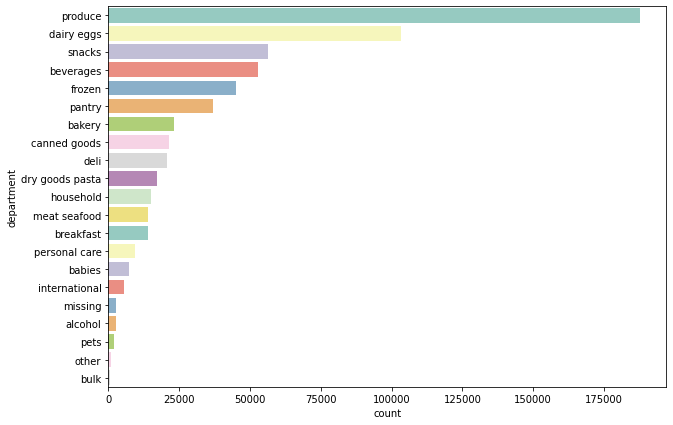

In [ ]:
#Most Popular Departments
plt.figure(figsize=(10,7))
sns.countplot(y='department', palette='Set3',data=order_details,
  order=order_details['department'].value_counts().index)
plt.show()

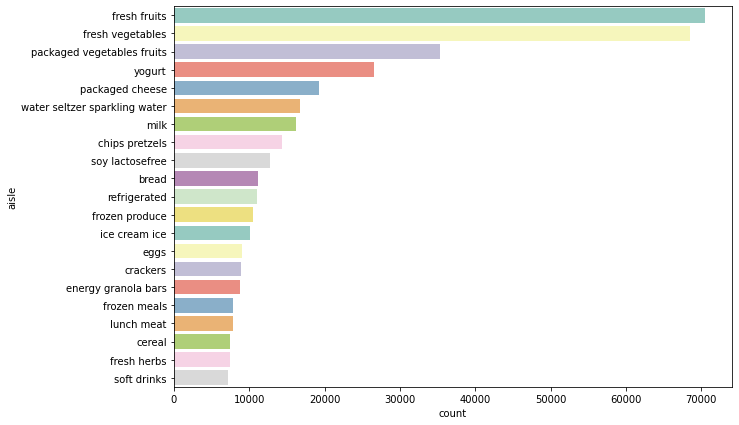

In [ ]:
#Top 20 in Aisle Popularity, there were too many unique aisles to include all
plt.figure(figsize=(10,7))
sns.countplot(y='aisle', palette='Set3',data=order_details,
  order=order_details['aisle'].value_counts().iloc[:21].index)
plt.show()

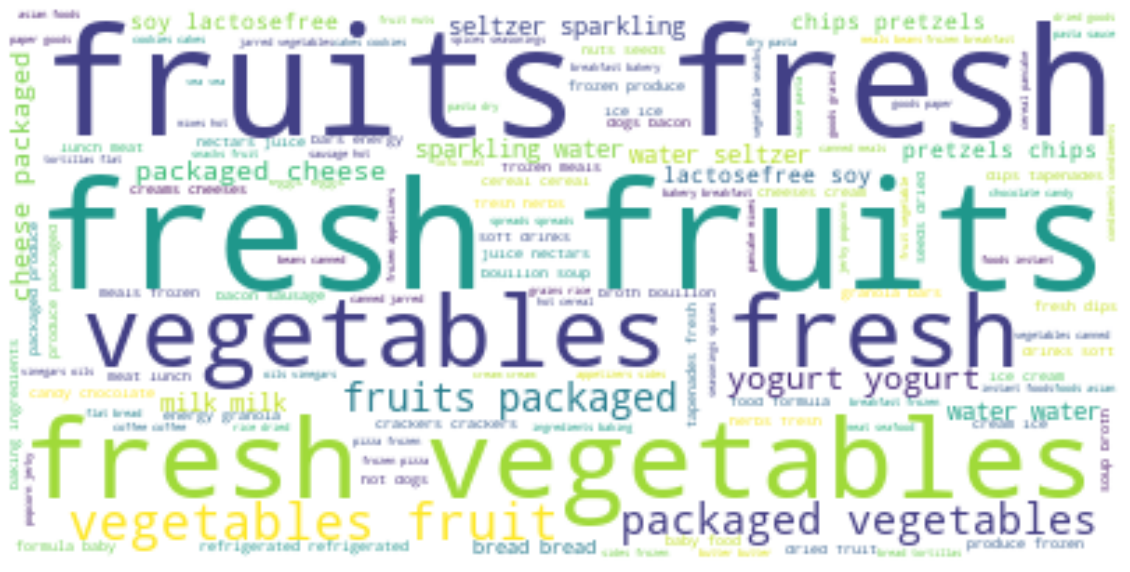

In [ ]:
# Generate a word cloud image
wordcloud = WordCloud(background_color='white').generate(" ".join(order_details['aisle']))
plt.figure(figsize=(20,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

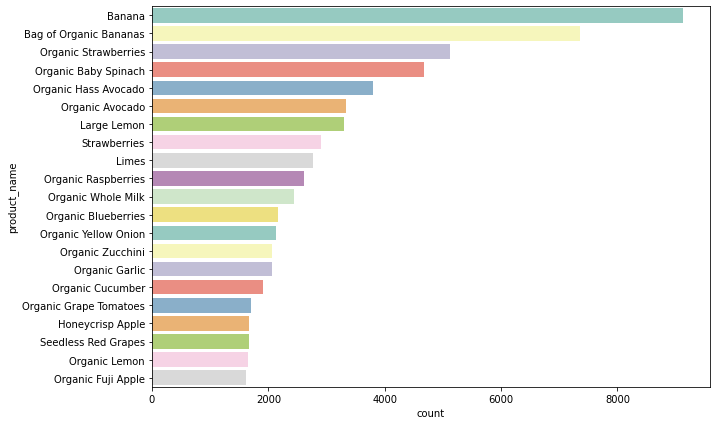

In [ ]:
#Top 20 in Product Popularity, there were too many unique products to include all
plt.figure(figsize=(10,7))
sns.countplot(y='product_name', palette='Set3',data=order_details,
  order=order_details['product_name'].value_counts().iloc[:21].index)
plt.show()

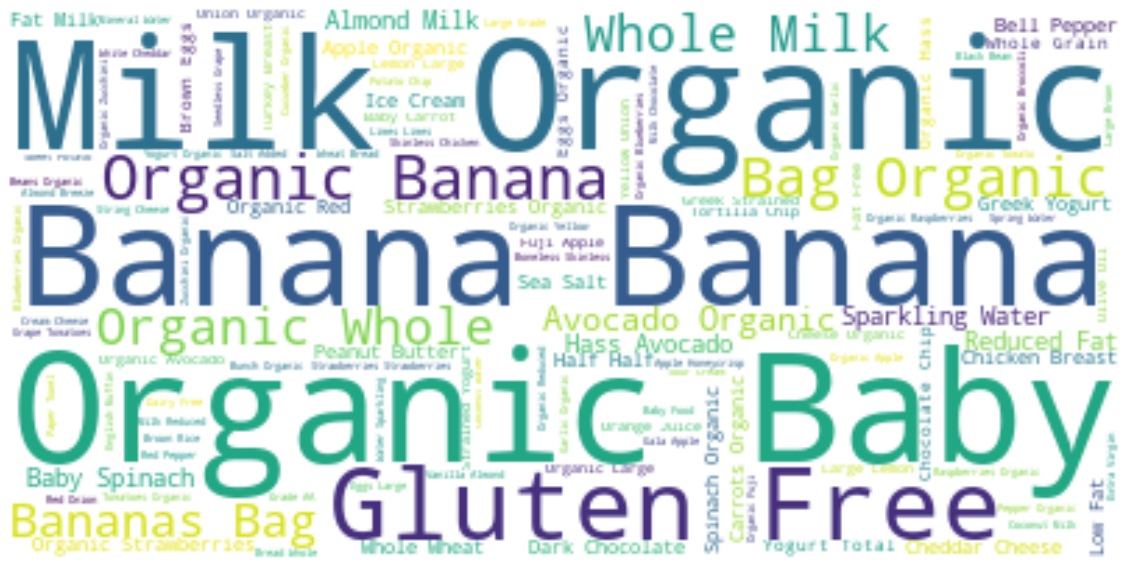

In [ ]:
# Generate a word cloud image
wordcloud = WordCloud(background_color='white').generate(" ".join(order_details['product_name']))
plt.figure(figsize=(20,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

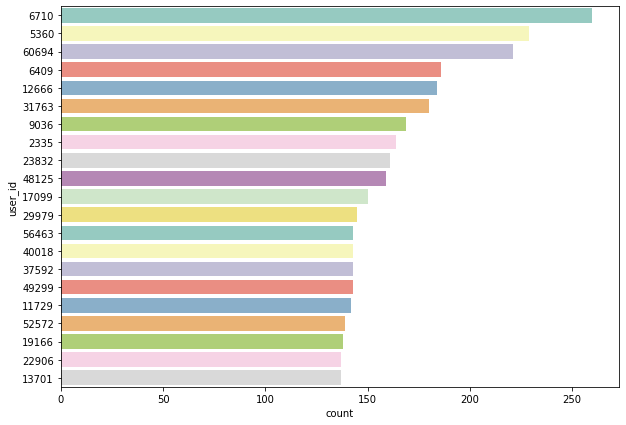

In [ ]:
#Top 20 Users
plt.figure(figsize=(10,7))
sns.countplot(y='user_id', palette='Set3',data=order_details,
  order=order_details['user_id'].value_counts().iloc[:21].index)
plt.show()

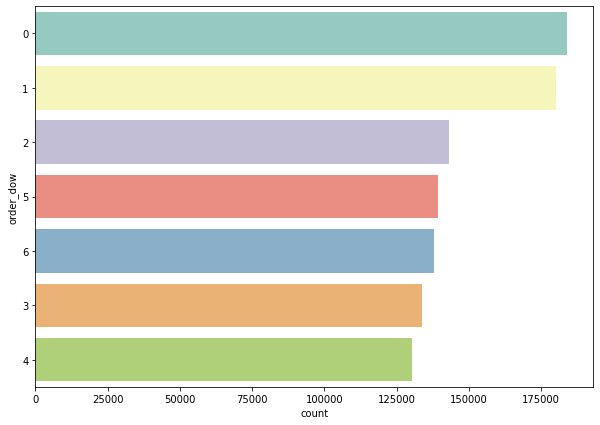

In [ ]:
#Most Popular Day to Order
#Days are Numbered were 0=Saturday through 6=Friday
plt.figure(figsize=(10,7))
sns.countplot(y='order_dow', palette='Set3',data=orders_df,
  order=orders_df['order_dow'].value_counts().index)
plt.show()

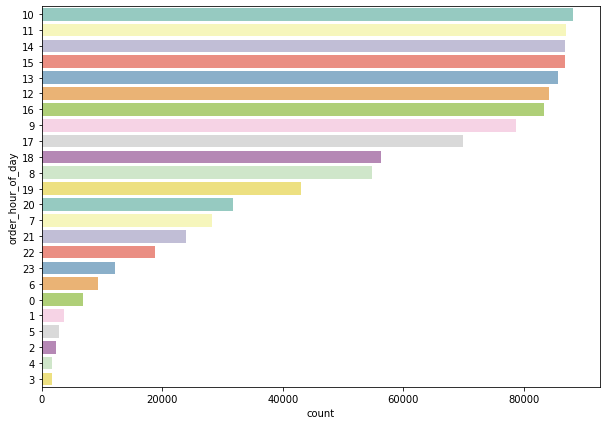

In [ ]:
#Most popular time to purchase
plt.figure(figsize=(10,7))
sns.countplot(y='order_hour_of_day', palette='Set3',data=orders_df,
  order=orders_df['order_hour_of_day'].value_counts().index)
plt.show()

**Descriptive Statistics**

Let's look into how often & how much users purchase overall and per order. 

In [ ]:
#How many orders do users make?
order_details.groupby('user_id')['order_id'].nunique().describe()

count    41234.000000
mean         1.504317
std          0.887969
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         13.000000
Name: order_id, dtype: float64

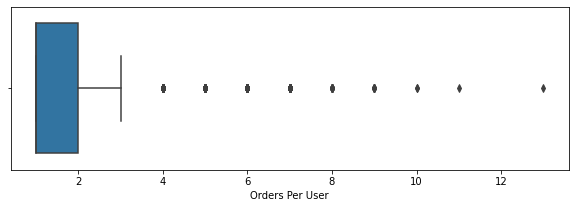

In [ ]:
#visualize
plt.figure (figsize=(10,3))
sns.boxplot(x=order_details.groupby('user_id')['order_id'].nunique())
plt.xlabel('Orders Per User')
plt.show()

In [ ]:
#How many items do customers order over the year?
order_details.groupby('user_id')['qty_purchased'].sum().describe()

count    41234.000000
mean       131.961440
std        222.065457
min          1.000000
25%         21.000000
50%         55.000000
75%        153.000000
max       8183.000000
Name: qty_purchased, dtype: float64

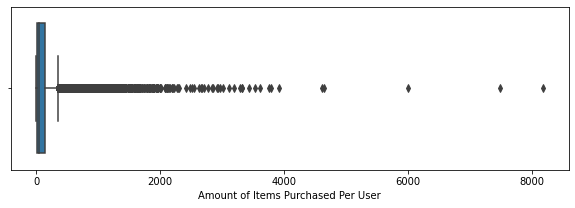

In [ ]:
#visualize
plt.figure (figsize=(10,3))
sns.boxplot(order_details.groupby('user_id')['qty_purchased'].sum())
plt.xlabel('Amount of Items Purchased Per User')
plt.show()

In [ ]:
#How many items per order?
order_details.groupby('order_id')['qty_purchased'].sum().describe()

count    62029.000000
mean        87.721840
std        143.892904
min          1.000000
25%         15.000000
50%         45.000000
75%        105.000000
max       8128.000000
Name: qty_purchased, dtype: float64

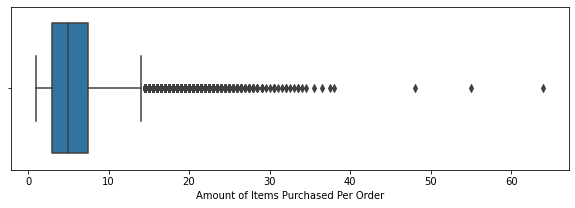

In [ ]:
#visualize
plt.figure (figsize=(10,3))
sns.boxplot(order_details.groupby('order_id')['qty_purchased'].mean())
plt.xlabel('Amount of Items Purchased Per Order')
plt.show()

In [ ]:
#How many times was each product ordered?
order_details.groupby('product_id')['qty_purchased'].sum().describe()

count    31728.000000
mean       171.498298
std        829.234361
min          1.000000
25%         12.000000
50%         33.000000
75%        102.000000
max      44769.000000
Name: qty_purchased, dtype: float64

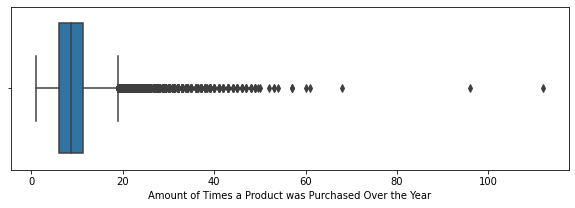

In [ ]:
#visualize
plt.figure (figsize=(10,3))
sns.boxplot(order_details.groupby('product_id')['qty_purchased'].mean())
plt.xlabel('Amount of Times a Product was Purchased Over the Year')
plt.show()

In [ ]:
#How long since last order?
orders_df.groupby('order_id')['days_since_prior_order'].mean().describe()

count    985475.000000
mean         11.102506
std           9.186663
min           0.000000
25%           4.000000
50%           7.000000
75%          15.000000
max          30.000000
Name: days_since_prior_order, dtype: float64

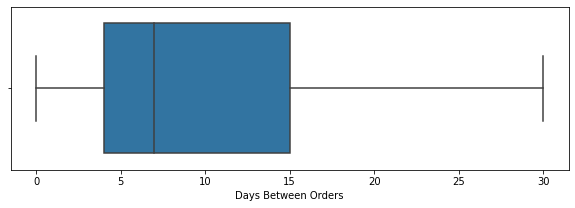

In [ ]:
plt.figure (figsize=(10,3))
sns.boxplot(orders_df.groupby('order_id')['days_since_prior_order'].mean())
plt.xlabel('Days Between Orders')
plt.show()

# **Simple Recommender System**

We will use a weighted rating formula as a metric or score for recommending most popular products.

Mathematically, it is represented as:

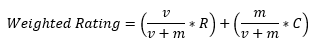

*   **v** is the amount of times a product was purchased.
*   **m** is the minimum amount of times a product was purchased in order to be able to make it into the list. Must be in 90th percentile. 
*   **R** is the percent of total product purchases a specific product was purchased.
*   **C** is the mean amount of times a product was purchased in across the data.

In [ ]:
#Calculate mean amount of orders a product was purchased in across the data
C = product_hist['qty_purchased'].mean()
print(C)

171.4982980332829


In [ ]:
#calculate m, the minimum amount of orders a product was purchased in, in order to 
#make it into the reccomendation system. 
m=product_hist['qty_purchased'].quantile(0.90)
print(m)

312.0


In [ ]:
#create a df that contains products that were purchased >= 312 times
q_product_hist = product_hist.copy().loc[product_hist['qty_purchased'] >= m]
q_product_hist.shape

(3179, 4)

In [ ]:
product_hist.shape

(31728, 4)

In [ ]:
#Calculate weighted pruchase for each qaulified product.
def weighted_purchase(x, m=m, C=C):
  v = x['qty_purchased']
  R = x['qty_purchased_percent']
  #calculate Weighted Rating
  weighted_rating = ((v/(v+m)*R) + ((m/(m+v))*C))
  return weighted_rating

In [ ]:
#Define a new feature of q_product_hist & calculate it's value with weighted_rating
q_product_hist['score'] = q_product_hist.apply(weighted_purchase, axis=1)

In [ ]:
#sort based on calculated score
q_product_hist = q_product_hist.sort_values('score', ascending=False)

#view top 20
q_product_hist.head(21)

,product_id,product_name,qty_purchased,qty_purchased_percent,score
7638,12118,Organic Whole Grain Spanish Rice,312,0.005734,85.752016
9669,15226,Whole Rye Bread,312,0.005734,85.752016
14854,23198,Organic Chicken Drumsticks,312,0.005734,85.752016
1525,2371,Natural Uncured Beef Hot Dog,312,0.005734,85.752016
8102,12858,Pecan Pie Fruit & Nut Food Bar,312,0.005734,85.752016
26193,41006,Organic Onion Powder,312,0.005734,85.752016
21659,33911,Zero Calorie Cream Soda,312,0.005734,85.752016
18240,28572,Premium Ice Cubes,313,0.005752,85.614831
18682,29256,Organic Udon Japanese Wheat Noodles,313,0.005752,85.614831
27003,42242,Cacao Powder,313,0.005752,85.614831


In [ ]:
q_product_hist = pd.DataFrame(data = q_product_hist)
q_product_hist.to_csv('top_products_details.csv')

# **Personalized Similarity Recomednation Systems**

Here, we will consider users purchases' of different items, as well as purchases of similar users, to recommend the best products for future pruchases. 

Some factors to consider while creating this, and many recommendation models, is sparseness of data, the high amounts of items a user has not purchased, and users for which the system has no prior information to make recomendations.  for becuase they don't have prior purchases.

In this section, we will focus on creating systems that recomend products based on user similarity and product similarity. Then, that information will be used to generate new features that will be used in an Extreme Gradient Boosting, XGBoost, model to predict the weighted rating we created earlier. 

Finally, we'll creat an Alternatint Leas Squares Model to make recommendations or products for users and users for products. 

In [ ]:
#calculate score for each product in product hist
product_hist['score'] = product_hist.apply(weighted_purchase, axis=1)
product_hist

,product_id,product_name,qty_purchased,qty_purchased_percent,score
0,1,Chocolate Sandwich Cookies,265,0.004870,92.736152
1,2,All-Seasons Salt,82,0.001507,135.806072
2,3,Robust Golden Unsweetened Oolong Tea,6,0.000110,168.262483
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,91,0.001672,132.773254
4,8,Cut Russet Potatoes Steam N' Mash,73,0.001342,138.980693
...,...,...,...,...,...
31723,49681,Spaghetti with Meatballs and Sauce Meal,33,0.000606,155.094171
31724,49682,California Limeade,15,0.000276,163.631416
31725,49683,Cucumber Kirby,11082,0.203665,4.894197
31726,49686,Artisan Baguette,1,0.000018,170.950380


In [ ]:
#investigate descriptive statistics of score column
product_hist['score'].describe()

count    31728.000000
mean       140.521698
std         35.711919
min          2.003987
25%        129.245556
50%        155.094171
75%        165.146517
max        170.950380
Name: score, dtype: float64

In [ ]:
#split into training and test sets
product_train = product_hist
product_train, product_test = train_test_split(product_train, test_size = 0.8, random_state= 24)

In [ ]:
product_train

,product_id,product_name,qty_purchased,qty_purchased_percent,score,user_id
97066,13176,Bag of Organic Bananas,35366,0.649955,2.144004,29754
334121,40199,Chocolate Chip Cookies,1859,0.034165,24.675717,37645
290816,34530,Organic Chicken Thighs,1342,0.024663,32.370355,25998
291127,34582,Natural Creamy Peanut Butter Spread,389,0.007149,76.334165,21791
728,117,Petit Suisse Fruit,374,0.006873,78.002973,1866
...,...,...,...,...,...,...
268644,31801,9 Inch Plates,627,0.011523,56.991154,16443
414849,48745,Globe Eggplant,3884,0.071380,12.818091,28140
211136,25659,Organic Coconut Milk,5207,0.095694,9.785423,15790
899,141,Restaurant Style Organic Chia & Quinoa Tortill...,736,0.013526,51.066245,41674


In [ ]:
product_test

,product_id,product_name,qty_purchased,qty_purchased_percent,score,user_id
262407,31338,Classic Almond Butter,1019,0.018727,40.215291,3392
340841,40992,Chopped Tomatoes,749,0.013765,50.440885,43255
131744,17794,Carrots,11988,0.220315,4.564927,46429
223869,26940,Organic Large Green Asparagus,3761,0.069120,13.200940,12655
146667,19478,Organic Marinara Pasta Sauce,1314,0.024149,32.926937,9820
...,...,...,...,...,...,...
355475,42736,Unsalted Butter,6298,0.115744,8.205208,61632
368778,44359,Organic Small Bunch Celery,12124,0.222814,4.519851,16412
391453,46906,Grape White/Green Seedless,6493,0.119328,7.976821,13299
392034,46941,Provolone Slices,769,0.014133,49.508175,29328


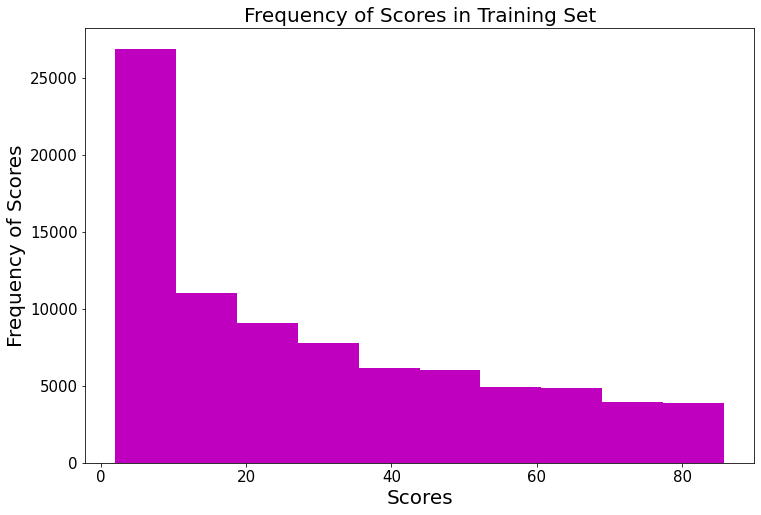

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(product_train['score'], color='m')
plt.tick_params(labelsize = 15)
plt.title('Frequency of Scores in Training Set', fontsize = 20)
plt.xlabel('Scores', fontsize = 20)
plt.ylabel('Frequency of Scores', fontsize = 20)
plt.show()

**Simple Similar Product Recomendation System**

In [ ]:
#create user-item sparse matrix function
def get_user_item_sparse_matrix(df):
  sparse_data = sparse.csr_matrix((df.score, (df.user_id, df.product_id)))
  return sparse_data

In [ ]:
#Apply user item sparse matrix function to training data
product_train_sparse_data = get_user_item_sparse_matrix(product_train)

In [ ]:
#Apply user item sparse matrix function to testing data
product_test_sparse_data = get_user_item_sparse_matrix(product_test)

In [ ]:
#global average score
global_average_score = product_train_sparse_data.sum()/product_train_sparse_data.count_nonzero()
print('Global Average Score: ', global_average_score)

Global Average Score:  29.274069968962355


In [ ]:
#Function to calculate average score from sparse matrix
def get_average_score(sparse_matrix, is_user):
  ax = 1 if is_user else 0
  sum_of_scores = sparse_matrix.sum(axis= ax).A1
  num_of_scores = (sparse_matrix !=0).sum(axis = ax).A1
  rows, cols = sparse_matrix.shape
  average_score = {i: sum_of_scores[i]/num_of_scores[i] for i in range(rows if is_user else cols) if num_of_scores[i]!=0}
  return average_score

In [ ]:
#average user score
avg_user_score = get_average_score(product_train_sparse_data, True)

In [ ]:
#Get average user score of user 50, just to see what happens
avg_user_score[50]

7.1650996810832055

In [ ]:
#average product score
avg_product_score = get_average_score(product_train_sparse_data, False)

In [ ]:
#Get average product score of item 14814, just to see what happens
avg_product_score[14814]

48.25892050225302

In [ ]:
#Check cold start problem for user
total_users = len(np.unique(product_hist['user_id']))
train_users = len(avg_user_score)
remaining_users = total_users - train_users
percent_remaining_users = (remaining_users/total_users)*100
print('Total Number of Users: ', total_users)
print('Training Set Users: ', train_users)
print('Number of Users Outside Training Set: {} ({}%)'.format(remaining_users, percent_remaining_users))

Total Number of Users:  40004
Training Set Users:  29905
Number of Users Outside Training Set: 10099 (25.24497550244976%)


In [ ]:
#Check cold start problem for product
total_products = len(np.unique(product_hist['product_id']))
train_products = len(avg_product_score)
remaining_products = total_products - train_products
percent_remaining_products = (remaining_products/total_products)*100
print('Total Number of Products: ', total_products)
print('Training Set Products: ', train_products)
print('Number of Products Outside Training Set: {} ({}%)'.format(remaining_products, percent_remaining_products))

Total Number of Products:  3179
Training Set Products:  3176
Number of Products Outside Training Set: 3 (0.09436929852154766%)


Both users and products bring up the cold start problem. Meaning, they both will have some observations with no proper score available. 

**Similarity Computation for Top 100 Users**

In [ ]:
#Function to find Target User Similarity Matrix to top 100 users
def compute_user_similarity(sparse_matrix, limit = 100):
  row_index, col_index = sparse_matrix.nonzero()
  rows = np.unique(row_index)
  similar_arr = np.zeros(61700).reshape(617,100)

  for row in rows[:limit]:
    sim = cosine_similarity(sparse_matrix.getrow(row), product_train_sparse_data).ravel()
    similar_indices = sim.argsort()[-limit:]
    similar = sim[similar_indices]
    similar_arr[row] = similar

  return similar_arr 

In [ ]:
#Run function and view for user 10
similar_user_matrix= compute_user_similarity(product_train_sparse_data, 100)
similar_user_matrix[10]

array([0.12677068, 0.12863338, 0.13081766, 0.13091498, 0.13091498,
       0.13091498, 0.13091498, 0.13793695, 0.14127977, 0.14127977,
       0.14127977, 0.14127977, 0.14127977, 0.14127977, 0.1417615 ,
       0.14594562, 0.14649699, 0.14664943, 0.14716143, 0.14804583,
       0.14952995, 0.1498573 , 0.15033541, 0.15362875, 0.15367778,
       0.15383721, 0.15386528, 0.15431759, 0.15453498, 0.15753316,
       0.16033956, 0.16125346, 0.16248907, 0.16248907, 0.16248907,
       0.16248907, 0.16358088, 0.16736604, 0.17105651, 0.1714354 ,
       0.17432932, 0.17621666, 0.17703707, 0.1808729 , 0.18098146,
       0.18663564, 0.18828732, 0.18912332, 0.19076166, 0.19076166,
       0.19076166, 0.19076166, 0.19076166, 0.19076166, 0.19080484,
       0.19766768, 0.19958149, 0.20012331, 0.20132517, 0.20132517,
       0.20132517, 0.2042731 , 0.20915568, 0.20922703, 0.211719  ,
       0.211719  , 0.22107262, 0.23396436, 0.30103864, 0.30402212,
       0.30613627, 0.30694473, 0.34307485, 0.38930775, 0.39898

In [ ]:
sim_user_output = pd.DataFrame(data=similar_user_matrix[10])

In [ ]:
#export similiar user output to a csv
sim_user_output.to_csv('sim_user_output.csv')

**Compute Product Similarity Matrix**

In [ ]:
#Function for Product Similarity Matrix
def compute_prodcut_similarity_count(sparse_matrix, product_hist, product_id):
  similarity = cosine_similarity(sparse_matrix.T, dense_output=False)
  num_similar_products = product_hist.loc[product_id][1],similarity[product_id].count_nonzero()
  return num_similar_products

In [ ]:
#Find a similar product for product 33120 organic egg whites
similar_products = compute_prodcut_similarity_count(product_train_sparse_data, product_hist, 33120)
print('Similar Products = ', similar_products)

Similar Products =  ('100% Whole Wheat Bread', 240)


In [ ]:
#Find a similar product for product 6550, organic brown eggs
similar_products = compute_prodcut_similarity_count(product_train_sparse_data, product_hist, 6550)
print('Similar Products = ', similar_products)

Similar Products =  ('Hickory Smoked Turkey Breast', 23)




**Create a Sample Sparse Matrix**

We will create a function to generate a Sample Sparse Matrix. This will allow us to generate new similarity features from the sample sparse matrix. 

In [ ]:
def get_sample_sparse_matrix(sparse_matrix, num_users, num_products):
  users, products, score = sparse.find(sparse_matrix)
  unique_users = np.unique(users)
  unique_products = np.unique(products)
  np.random.seed(15)
  user = np.random.choice(unique_users, num_users, replace = False)
  product = np.random.choice(unique_products, num_products, replace=True)
  mask = np.logical_and(np.isin(users, user), np.isin(products, product))
  sparse_matrix = sparse.csr_matrix((score[mask],(users[mask], products[mask])),
                                    shape = (max(user)+1, max(product)+1))
  return sparse_matrix

In [ ]:
#Sample Sparse Matrix for Training Data
train_sample_sparse_matrix = get_sample_sparse_matrix(product_train_sparse_data, 400, 100)

In [ ]:
train_sample_sparse_matrix

<62884x49248 sparse matrix of type '<class 'numpy.float64'>'
	with 37 stored elements in Compressed Sparse Row format>

In [ ]:
#Sample Sparse Matrix for Test Data
test_sample_sparse_matrix = get_sample_sparse_matrix(product_test_sparse_data, 400, 100)

In [ ]:
test_sample_sparse_matrix

<62974x49622 sparse matrix of type '<class 'numpy.float64'>'
	with 129 stored elements in Compressed Sparse Row format>

**Generating Similar Features**

The following function will recommend a similar product to a user and report scores for that product of 5 similar users and 5 similar products. 

In [ ]:
def create_new_similar_features(sample_sparse_matrix):
    global_avg_score = get_average_score(sample_sparse_matrix, False)
    global_avg_users = get_average_score(sample_sparse_matrix, True)
    global_avg_products = get_average_score(sample_sparse_matrix, False)
    sample_train_users, sample_train_products, sample_train_scores = sparse.find(sample_sparse_matrix)
    new_features_csv = open('new_features.csv', mode='w')

    for user, product, score in zip(sample_train_users, sample_train_products, sample_train_scores):
      similar_arr = list()
      similar_arr.append(user)
      similar_arr.append(product)
      similar_arr.append(sample_sparse_matrix.sum()/sample_sparse_matrix.count_nonzero())

      similar_users = cosine_similarity(sample_sparse_matrix[user], sample_sparse_matrix).ravel()
      indices = np.argsort(-similar_users)[1:]
      scores = sample_sparse_matrix[indices, product].toarray().ravel()
      top_similar_user_scores = list(scores[scores !=0][:5])
      top_similar_user_scores.extend([global_avg_score[product]]*(5-len(scores)))
      similar_arr.extend(top_similar_user_scores)

      similar_products = cosine_similarity(sample_sparse_matrix[:,product].T, sample_sparse_matrix.T).ravel()
      similar_products_indices = np.argsort(-similar_products)[1:]
      similar_products_scores = sample_sparse_matrix[user,similar_products_indices].toarray().ravel()
      top_similar_products_scores = list(similar_products_scores[similar_products_scores !=0][:5])
      top_similar_products_scores.extend([global_avg_users[user]]*(5-len(top_similar_products_scores)))
      similar_arr.extend(top_similar_products_scores)

      similar_arr.append(global_avg_users[user])
      similar_arr.append(global_avg_products[product])
      similar_arr.append(score)

      new_features_csv.write(','.join(map(str,similar_arr)))
      new_features_csv.write('\n')

    new_features_csv.close()     
    
    new_features_df = pd.read_csv('new_features.csv', names = ['user_id', 
          'product_id', 'global_avg', 'similar_user_score1', 'similar_user_score2', 
          'similar_user_score3', 'similar_user_score4', 'similar_user_score5', 
          'similar_product1', 'similar_product2', 'similar_product3', 
          'similar_product4', 'similar_product5', 'user_avg', 'product_avg', 'score'])
  
    return new_features_df


In [ ]:
#Generate Similar Features for the Training Data
train_new_similar_features = create_new_similar_features(train_sample_sparse_matrix)

In [ ]:
train_new_similar_features = train_new_similar_features.fillna(0)
train_new_similar_features

,user_id,product_id,global_avg,similar_user_score1,similar_user_score2,similar_user_score3,similar_user_score4,similar_user_score5,similar_product1,similar_product2,similar_product3,similar_product4,similar_product5,user_avg,product_avg,score
0,27207,2611,30.414249,32.626404,32.626404,32.626404,32.626404,32.626404,32.626404,32.626404,32.626404,0.000000,0.000000,0.0,0.0,0.0
1,4409,4605,30.414249,4.197259,4.197259,4.197259,4.197259,4.197259,4.197259,4.197259,4.197259,4.197259,4.197259,0.0,0.0,0.0
2,26571,4605,30.414249,4.197259,4.197259,4.197259,4.197259,4.197259,4.197259,4.197259,4.197259,4.197259,4.197259,0.0,0.0,0.0
3,52653,4605,30.414249,4.197259,4.197259,4.197259,4.197259,4.197259,4.197259,4.197259,4.197259,4.197259,4.197259,0.0,0.0,0.0
4,6134,4957,30.414249,16.578531,16.578531,16.578531,16.578531,16.578531,16.578531,16.578531,16.578531,16.578531,0.000000,0.0,0.0,0.0
5,62883,4957,30.414249,16.578531,16.578531,16.578531,16.578531,16.578531,16.578531,16.578531,16.578531,16.578531,0.000000,0.0,0.0,0.0
6,13921,7753,30.414249,79.746405,79.746405,79.746405,79.746405,79.746405,79.746405,79.746405,79.746405,0.000000,0.000000,0.0,0.0,0.0
7,60256,8021,30.414249,10.146307,10.146307,10.146307,10.146307,10.146307,10.146307,10.146307,10.146307,0.000000,0.000000,0.0,0.0,0.0
8,33078,9510,30.414249,78.460388,78.460388,78.460388,78.460388,78.460388,78.460388,78.460388,78.460388,0.000000,0.000000,0.0,0.0,0.0
9,17226,10798,30.414249,57.915966,57.915966,57.915966,57.915966,57.915966,57.915966,57.915966,57.915966,0.000000,0.000000,0.0,0.0,0.0


In [ ]:
#Generate Similar Features for Test Data
test_new_similar_features = create_new_similar_features(test_sample_sparse_matrix)

In [ ]:
test_new_similar_features = test_new_similar_features.fillna(0)
test_new_similar_features.head()

,user_id,product_id,global_avg,similar_user_score1,similar_user_score2,similar_user_score3,similar_user_score4,similar_user_score5,similar_product1,similar_product2,similar_product3,similar_product4,similar_product5,user_avg,product_avg,score
0,28681,1364,27.277687,15.228959,38.404566,38.404566,38.404566,38.404566,38.404566,61.580173,61.580173,0.000000,0.0,0.0,0.0,0.0
1,53381,3098,27.277687,46.178303,4.806634,25.492469,25.492469,25.492469,25.492469,25.492469,46.178303,46.178303,0.0,0.0,0.0,0.0
2,60488,3098,27.277687,46.178303,46.178303,46.178303,46.178303,46.178303,46.178303,46.178303,46.178303,46.178303,0.0,0.0,0.0,0.0
3,3332,4753,27.277687,84.935440,8.711080,46.823260,46.823260,46.823260,46.823260,46.823260,84.935440,84.935440,0.0,0.0,0.0,0.0
4,11409,4753,27.277687,84.935440,84.935440,84.935440,84.935440,84.935440,84.935440,84.935440,84.935440,84.935440,0.0,0.0,0.0,0.0


In [ ]:
test_new_similar_features

,user_id,product_id,global_avg,similar_user_score1,similar_user_score2,similar_user_score3,similar_user_score4,similar_user_score5,similar_product1,similar_product2,similar_product3,similar_product4,similar_product5,user_avg,product_avg,score
0,28681,1364,27.277687,15.228959,38.404566,38.404566,38.404566,38.404566,38.404566,61.580173,61.580173,0.000000,0.0,0.0,0.0,0.0
1,53381,3098,27.277687,46.178303,4.806634,25.492469,25.492469,25.492469,25.492469,25.492469,46.178303,46.178303,0.0,0.0,0.0,0.0
2,60488,3098,27.277687,46.178303,46.178303,46.178303,46.178303,46.178303,46.178303,46.178303,46.178303,46.178303,0.0,0.0,0.0,0.0
3,3332,4753,27.277687,84.935440,8.711080,46.823260,46.823260,46.823260,46.823260,46.823260,84.935440,84.935440,0.0,0.0,0.0,0.0
4,11409,4753,27.277687,84.935440,84.935440,84.935440,84.935440,84.935440,84.935440,84.935440,84.935440,84.935440,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,47887,46522,27.277687,12.546175,20.169144,20.169144,20.169144,20.169144,20.169144,27.792114,27.792114,0.000000,0.0,0.0,0.0,0.0
125,5337,47993,27.277687,57.978689,57.978689,57.978689,57.978689,57.978689,57.978689,57.978689,57.978689,0.000000,0.0,0.0,0.0,0.0
126,56988,48450,27.277687,73.002355,73.002355,73.002355,73.002355,73.002355,73.002355,73.002355,73.002355,0.000000,0.0,0.0,0.0,0.0
127,8396,49279,27.277687,67.480102,67.480102,67.480102,67.480102,67.480102,67.480102,67.480102,67.480102,67.480102,0.0,0.0,0.0,0.0


In [ ]:
#export user_recs to a csv
test_new_similar_features.to_csv('test_new_similar_features.csv')

## **ALS Model Recommendation System**

This will take our large matrix and factor into a smaller representaion of our original matrix through alternating least squares. ALS creates two, or more, lower dimensional matrices, that when multiplied together, the product is equivalent to the larger, original matrix. 

To find the best hyperparameters, a tuning exercise was used but is very timley to run. The tuning exercise started by testing single models and finished with an inbuilt method that tested many values for hyperparameters and returned the best one, based on RMSE. In an effort to run through code faster, the tuning exercise has been commented out but a screenshot of the output is shown. 

In [ ]:
#initialize spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Recommendation_system').getOrCreate()

In [ ]:
#Convert product_hist to spark df
spark_df = spark.createDataFrame(product_hist[['user_id', 'product_id', 'score']])

In [ ]:
#check data type of product_id, as ALS only accepts integers for product id's
dict(spark_df.dtypes)['product_id']

'bigint'

In [ ]:
#check data type of user_id, as ALS only accepts integers for user_id's
dict(spark_df.dtypes)['user_id']

'bigint'

In [ ]:
#Split data into train & test set
(train, test) = spark_df.randomSplit([0.8, 0.2], seed=124)

In [ ]:
# #create model to test for best hyperparameters
# als = ALS(userCol='user_id', itemCol='product_id', ratingCol='score',
#           coldStartStrategy='drop', nonnegative=True)
# #tune model using ParamGridBuilder
# param_grid = ParamGridBuilder() \
#             .addGrid(als.rank, [20, 25, 30]) \
#             .addGrid(als.maxIter, [21,23,25]]) \
#             .addGrid(als.regParam, [0.05, 0.07, 0.09]) \
#             .build()
# #define evaluator as RMSE
# evaluator = RegressionEvaluator(metricName='rmse', labelCol='score', 
#                                 predictionCol='prediction')

# #Build cross validation using CrossValidator
# cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, 
#                     evaluator=evaluator, numFolds=5)

# #fit ALS model from tuning
# model = cv.fit(train)

# #extract best model from tuning
# best_model = model.bestModel

# #generate predictions and evaluate using RMSE
# predictions = best_model.transform(test)
# rmse=evaluator.evaluate(predictions)

# #print eval metrics & parameters
# print('RMSE: '+str(rmse))
# print('***Best Model***')
# print('   Rank: '+str(best_model.rank))
# print('   MaxIter: '+str(best_model._java_obj.parent().getMaxIter()))
# print('   RegParam: '+str(best_model._java_obj.parent().getRegParam()))

Best Model Output of Tuning Parameter Shown Above (to save time when running):

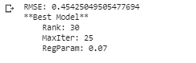

In [ ]:
#best model from tuning exercise, to save time.
als=ALS(maxIter=20,regParam=0.05, rank=21 ,userCol='user_id',itemCol='product_id',
        ratingCol='score',coldStartStrategy="drop",nonnegative=True)

model = als.fit(train)

In [ ]:
#generate predictions and evaluate rmse
evaluator=RegressionEvaluator(metricName="rmse",labelCol='score',
                              predictionCol='prediction')

#generate predictions and evaluate using RMSE
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)
print('RMSE: '+str(rmse))

predictions.show()

RMSE: 0.9104000554730832
+-------+----------+------------------+----------+
|user_id|product_id|             score|prediction|
+-------+----------+------------------+----------+
|   3703|       148|52.008665595263416|  51.84115|
|  13951|       148|52.008665595263416|  51.87134|
|   1122|       148|52.008665595263416| 51.964783|
|   4258|       148|52.008665595263416|  51.91404|
|  37289|       148|52.008665595263416| 51.958103|
|  16624|       148|52.008665595263416|  52.05061|
|  38686|       148|52.008665595263416|  51.90243|
|  56808|       148|52.008665595263416| 51.843113|
|  33967|       148|52.008665595263416| 51.980095|
|  19215|      8638|62.369402975132786| 62.129055|
|  14154|      8638|62.369402975132786|  62.45209|
|  15602|      8638|62.369402975132786|  62.28525|
|  31615|      8638|62.369402975132786| 62.034317|
|  50665|      8638|62.369402975132786| 62.310986|
|  45008|      8638|62.369402975132786| 62.319717|
|  27986|      8638|62.369402975132786|  62.30902|
|  141

In [ ]:
#provide user recommendations
user_recs = model.recommendForAllUsers(10) 

In [ ]:
#view 10 rows of user_recs
user_recs.show(10)

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|    471|[[16714, 86.36776...|
|    496|[[16714, 86.20769...|
|    833|[[16714, 86.22747...|
|   1088|[[16714, 86.22996...|
|   1342|[[16714, 86.29578...|
|   1580|[[16714, 86.20744...|
|   1645|[[16714, 86.33160...|
|   1829|[[16714, 86.16099...|
|   1959|[[16714, 86.22692...|
|   2366|[[16714, 85.67737...|
+-------+--------------------+
only showing top 10 rows



In [ ]:
#export user_recs to a csv
user_recs.toPandas().to_csv('als_user_recs.csv')

In [ ]:
#provide item recommendations
item_recs = model.recommendForAllItems(10)

In [ ]:
#view 10 rows of item_recs
item_recs.show(10)

+----------+--------------------+
|product_id|     recommendations|
+----------+--------------------+
|     41890|[[39415, 82.48087...|
|     20382|[[39415, 83.18111...|
|     29993|[[39415, 53.28414...|
|     19204|[[5547, 84.09909]...|
|     34234|[[39415, 50.01036...|
|     42834|[[39415, 74.0533]...|
|     45615|[[39415, 71.43632...|
|     26706|[[39415, 72.98914...|
|     28836|[[39415, 57.88715...|
|     40386|[[39415, 72.41982...|
+----------+--------------------+
only showing top 10 rows



In [ ]:
#export item_recs to a csv
item_recs.toPandas().to_csv('als_item_recs.csv')

# **Conclusions**

Ultimately, the XGBRegressor model had a lower RMSE than the ALS method and is therefore a better method for this data. 

Describe your model in detail: why you chose it, why it works, what problem it solves, and how it will run in a production-like environment. 

Now that we've seen the two models in action, we know the XGBRegressor model performend better than the ALS model because it had a lower RMSE. 

This is how the XGBoost Model Works:
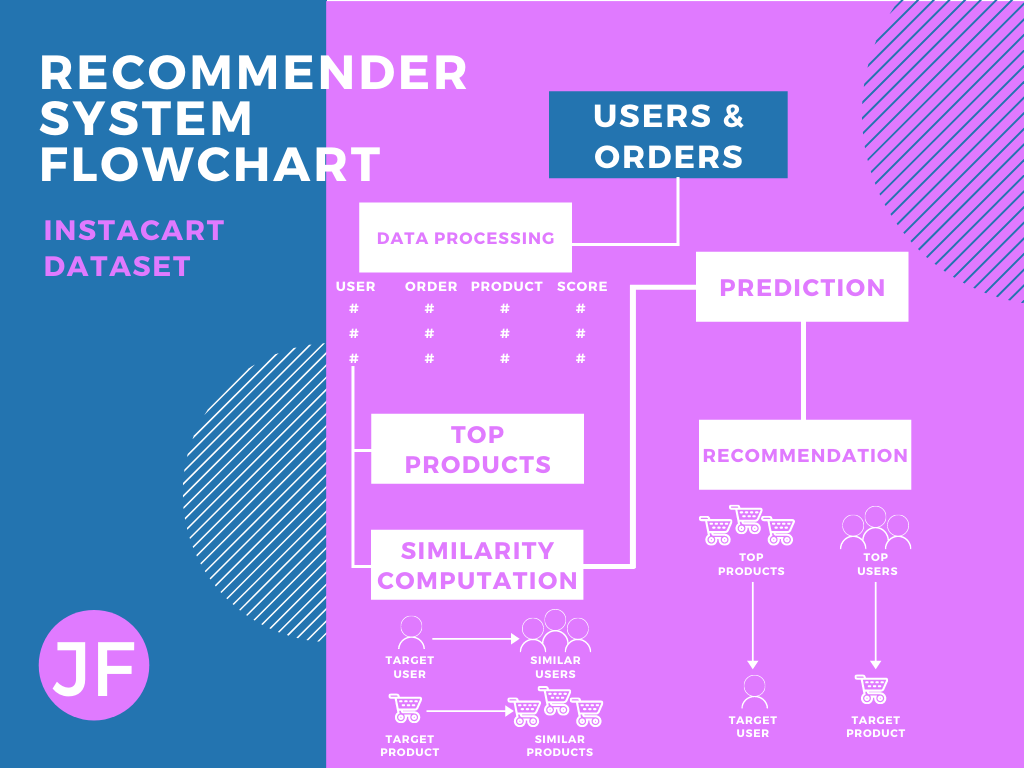


Instacart, or companies utizlizing this system, would simply need to continue inputting user & order information in, to get out recomendations. New users could automatically be recommended the top products. 